# SmartBank Customer Churn Model
### Lloyds Banking Group "Customer Retention Enhancement through Predictive Analytics" Initiative
### Analysis by: Breanna Williams
#### November 28, 2025

In [ ]:
# Base imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


# Stats imports
import scipy.stats.stats as stats
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, PowerTransformer, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score, PrecisionRecallDisplay, precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import shap
import pickle

In [87]:
data = pd.read_csv('../data/clean_customer_churn_data.csv')
data.head()

,CustomerID,ChurnStatus,Age,Gender,MaritalStatus,IncomeLevel,DaysSinceLastInteraction,ResolutionRate,LoginFrequency,ServiceUsage_Online Banking,ServiceUsage_Website,DaysSinceLastLogin,NumTransactions,DaysSinceLastTransaction,TransactionsPerLogin,RecencyScore,ActivityMomentum
0,1,0,62,M,Single,Low,274,1.0,34,0,0,71,1,279,0.028571,208.000000,0.162679
1,2,1,65,M,Married,Low,288,1.0,5,0,1,26,7,42,1.166667,118.666667,0.041783
2,3,0,18,M,Single,Low,128,1.0,3,0,1,46,6,84,1.500000,86.000000,0.034483
3,4,0,21,M,Widowed,Low,42,0.5,2,0,1,128,5,4,1.666667,58.000000,0.033898
4,5,0,21,M,Divorced,Medium,-1,-1.0,41,0,1,65,8,10,0.190476,24.666667,1.597403


---
### Split the Data

In [88]:
CustomerID = data['CustomerID'].copy()      # Save CustomerID for deployment
X = data.drop(['ChurnStatus', 'CustomerID'], axis=1)
y = data['ChurnStatus']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [90]:
# Checking sizes of split data
for i in [X_train, X_test, y_train, y_test]:
    print(len(i)/len(data))

0.8
0.2
0.8
0.2


---
### Preprocess the Data

In [91]:
# Seperating features by data type
numeric_columns = X_train.select_dtypes(include='number').columns.tolist()
nominal_columns = ['MaritalStatus', 'Gender'] 
ordinal_columns = ['IncomeLevel', ]

In [97]:
# Create preprocessing pipelines for different feature types
numeric_pipeline = make_pipeline(SimpleImputer(strategy='median'),
                                PowerTransformer(method='yeo-johnson'),        # Handles multi-directional skew
                                RobustScaler())                              # Normalizes features and handles outliers
                                                                    
nominal_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                OneHotEncoder(handle_unknown='ignore', sparse_output=False)) 

ordinal_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

In [98]:
# Create the ColumnTransformer to apply the pipelines
transformer = ColumnTransformer([
                        ('num', numeric_pipeline, numeric_columns),
                        ('nom', nominal_pipeline, nominal_columns),
                        ('ord', ordinal_pipeline, ordinal_columns)
                        ])

In [99]:
# Set transformer to output a pandas DataFrame with non-verbose feature names
transformer.set_output(transform="pandas")
transformer.set_params(verbose_feature_names_out=False)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('powertransformer',
                                                  PowerTransformer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['Age', 'DaysSinceLastInteraction',
                                  'ResolutionRate', 'LoginFrequency',
                                  'ServiceUsage_Online Banking',
                                  'ServiceUsage_Website', 'DaysSinceLastLogin',
                                  'NumTransactions', 'DaysSinceL...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['MaritalStatus', 'Gender']),
                                ('ord',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['IncomeLevel'])],
                  verbose_feature_names_out=False)

In [100]:
# Preprocess the Data
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

In [101]:
# Get feature names after transformation
feature_names = X_train_transformed.columns.tolist()

Comments:
- After preprocessing, most of our skew has been reduced using Power Transformation. Only the two ServiceUsage variables remain moderately skewed. 
- By using RobustScaler, all variables are on a similar scale. However, our new engineered features RecencyScore, ActivityMomentum, and TransactionPerLogin still have a large number of outliers present. This can be addressed in modeling using algorithms robust to outliers.

---
#### Defining Helper Functions for Model Evaluation and Visualization


In [102]:
def train_eval(model, X_train, y_train, cv_splits=5):
    """
    Fits model on full training data, runs CV on training data,
    and returns (results_df, fitted_model).
    """
    # 1. Cross-validation AUC on train
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    cv_auc = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv).mean()
    
    # 2. Fit on full training set
    fitted_model = model.fit(X_train, y_train)

    # 3. Train-set metrics (optional but nice)
    y_pred_train  = fitted_model.predict(X_train)
    y_proba_train = fitted_model.predict_proba(X_train)[:, 1]

    train_auc = roc_auc_score(y_train, y_proba_train)
    train_f1  = f1_score(y_train, y_pred_train)

    print("\n=== Classification Report (Train) ===")
    print(classification_report(y_train, y_pred_train))

    results = {
        "Dataset": "Train",
        "Model": fitted_model.__class__.__name__,
        "CV ROC-AUC": cv_auc.round(2),
        "Train ROC-AUC": train_auc.round(2),
        "Train F1": train_f1.round(2)
    }

    return pd.DataFrame([results]), fitted_model


In [103]:
results = []
def test_eval(fitted_model, X_test, y_test):
    """
    Uses an already-fitted model to evaluate on the test set.
    No fitting, no cross-validation.
    Returns a results dataframe.
    """
    
    y_pred_test  = fitted_model.predict(X_test)
    y_proba_test = fitted_model.predict_proba(X_test)[:, 1]

    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_proba_test)
    test_f1  = f1_score(y_test, y_pred_test)
    
    results.append({
        "Dataset":    "Test",
        "Model":      fitted_model.__class__.__name__,
        "ROC-AUC":    test_auc.round(2),
        "Precision":  test_precision.round(2),
        "Recall":     test_recall.round(2),
        "F1":         test_f1.round(2)
    })

    return pd.DataFrame(results)    

In [104]:
def plot_cm_pr(init_model, X, y, dataset='Test'):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    if dataset == 'Train':
        model = init_model.fit(X, y)
    else:
        model = init_model
        
    predictions = model.predict(X)

    # Normalized confusion matrix: normalize can be 'true', 'pred', 'all', or None
    cm = confusion_matrix(y, y_pred=predictions, labels=[0, 1], normalize='true')
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    cm_disp.plot(cmap=plt.cm.Blues, ax=axs[0], values_format='.2f')
    axs[0].set_title(f'Confusion Matrix ({dataset})')
    
    PrecisionRecallDisplay.from_estimator(model, X, y, ax=axs[1])
    axs[1].set_title(f'Precision–Recall Curve ({dataset})')
       
    
    plt.suptitle(f'{model.__class__.__name__} Confusion Matrix and Precision-Recall Curve ({dataset} Set)')
    plt.tight_layout()
    plt.show()

---
### Modeling

#### Linear Models:
#### 1) Base Model: Logistic Regression

In [105]:
logistic_model = LogisticRegression(class_weight='balanced', random_state=42) # class_weight='balanced' to handle class imbalance in target variable

In [106]:
train_results, logistic_fitted = train_eval(logistic_model, X_train_transformed, y_train)
train_results



=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       0.86      0.63      0.73       637
           1       0.29      0.58      0.38       163

    accuracy                           0.62       800
   macro avg       0.57      0.61      0.55       800
weighted avg       0.74      0.62      0.66       800



,Dataset,Model,CV ROC-AUC,Train ROC-AUC,Train F1
0,Train,LogisticRegression,0.56,0.64,0.38


In [107]:

test_results = test_eval(logistic_fitted, X_test_transformed, y_test)
test_results


,Dataset,Model,ROC-AUC,Precision,Recall,F1
0,Test,LogisticRegression,0.53,0.2,0.41,0.27


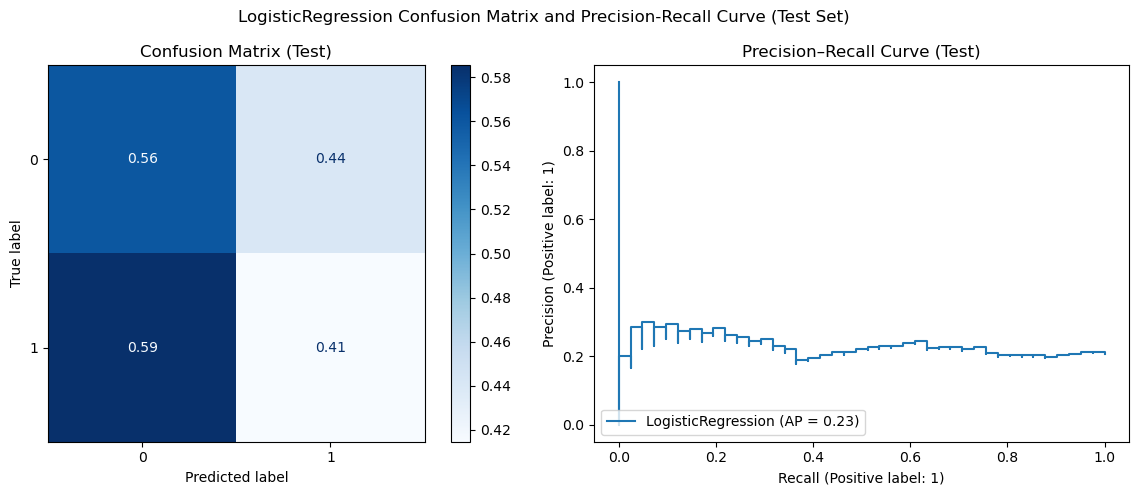

In [108]:

plot_cm_pr(logistic_fitted, X_test_transformed, y_test)

- We trained the logistic model with Synthetic Minority Oversampling Technique (SMOTE)  to best handle the class imbalance in the target variable. It creates synthetic samples of the minority class (customers who churn) to create a balanced dataset for training.

#### Ensemble Models:
#### 2) Random Forest Classifer Model
Random Forest Classifier is an ensemble learning method that constructs multiple decision trees during training and combines their predictions to improve accuracy and reduce overfitting. Each tree is built using a random subset of the data and features, allowing the model to capture diverse patterns in the data and enhance its generalization capabilities.

In [109]:
# Initializing a random forest model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

In [110]:
# Fitting a randomized search CV to find best hyperparameters
rf_params = {'n_estimators': [50, 100, 200], 
             'max_depth': [5, 10, 15, 20, None], 
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_rand_cv = RandomizedSearchCV(rf_model, rf_params, n_iter=50, cv=cv, scoring='roc_auc', random_state=42, n_jobs=-1)
best_rf = rf_rand_cv.fit(X_train_transformed, y_train).best_estimator_
best_rf

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [111]:
# Training the model
train_results, rf_fitted = train_eval(best_rf, X_train_transformed, y_train)
train_results


=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      1.00      1.00       163

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



,Dataset,Model,CV ROC-AUC,Train ROC-AUC,Train F1
0,Train,RandomForestClassifier,0.62,1.0,1.0


Train Set Findings:
- Precision, recall, f1-score, and train ROC_AUC are all 1.0 indicating probable overfitting. This is unsuprising given the model complexity and the small dataset size. However, we will evaluate on the test set to see how well the model generalizes.
- CV ROC_AUC results of 0.62 suggest that the model is about 12% better than random guessing, indicating weak predictive power.

In [112]:
# Evaluating on the test set
test_eval(rf_fitted, X_test_transformed, y_test)

,Dataset,Model,ROC-AUC,Precision,Recall,F1
0,Test,LogisticRegression,0.53,0.2,0.41,0.27
1,Test,RandomForestClassifier,0.57,0.5,0.05,0.09


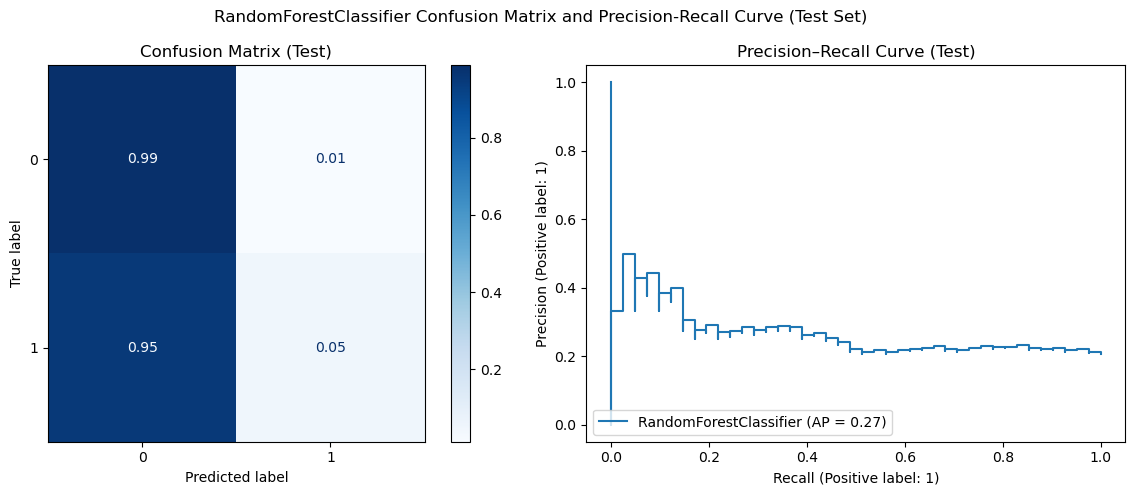

In [113]:
plot_cm_pr(best_rf, X_test_transformed, y_test)

Test Set Findings:
- Precision Score (0.33) - indicates that the model accurately identifies 33% of the customers it predicts will churn.
- Recall Score (0.02) - indicates that the model only identifies 2% of all actual churners in the test set.
- F1-Score (0.05) - indicates poor balance between precision and recall, suggesting the model struggles to effectively identify churners.
- ROC-AUC Score (0.57) - indicates the model has limited ability to distinguish between churners and non-churners, performing only 7% better than random guessing.
- As expected, the model did not generalize well to the test set. The f1-score showed virtually no balance between precision and recall.

#### 3) Gradient Boosting Classifier Model
Gradient Boosting Classifer is an ensemble learning technique that builds a series of weak learners (typically decision trees) sequentially, where each subsequent model attempts to correct the errors of the previous ones. It combines the predictions of multiple models to produce a final prediction, often resulting in improved accuracy and robustness compared to individual models.

In [114]:
# Initializing a gradient boosting model
gb_model = GradientBoostingClassifier(random_state=42)

In [115]:
# Fitting a randomized search CV to find best hyperparameters
gb_params = {'n_estimators': [100, 200, 300],
             'learning_rate': [0.01, 0.05, 0.1],
             'max_depth': [3, 5, 7, 10],
             'subsample': [0.7, 0.8, 0.9, 1.0],
             'min_samples_split': [2, 5, 10],
             'min_samples_leaf': [1, 2, 4]}
gb_rand_cv = RandomizedSearchCV(gb_model, gb_params, n_iter=50, cv=cv, scoring='roc_auc', random_state=42, n_jobs=-1)
best_gb = gb_rand_cv.fit(X_train_transformed, y_train).best_estimator_ 
best_gb

GradientBoostingClassifier(learning_rate=0.05, max_depth=7, min_samples_leaf=4,
                           min_samples_split=10, random_state=42,
                           subsample=0.8)

In [116]:
# Training the model
train_results, gb_fitted = train_eval(best_gb, X_train_transformed, y_train)
train_results


=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      0.98      0.99       163

    accuracy                           1.00       800
   macro avg       1.00      0.99      0.99       800
weighted avg       1.00      1.00      1.00       800



,Dataset,Model,CV ROC-AUC,Train ROC-AUC,Train F1
0,Train,GradientBoostingClassifier,0.62,1.0,0.99


Train Set Findings:
- Like the Random Forest model, precision, recall, f1-score, and train ROC_AUC are all 1.0 indicating probable overfitting. 
- CV ROC_AUC results of 0.67 suggests that the model is slightly better than the Random Forest model at seperating classes, being about 17% better than random guessing.

In [117]:
# Evaluating on the test set
test_eval(gb_fitted, X_test_transformed, y_test)

,Dataset,Model,ROC-AUC,Precision,Recall,F1
0,Test,LogisticRegression,0.53,0.20,0.41,0.27
1,Test,RandomForestClassifier,0.57,0.50,0.05,0.09
2,Test,GradientBoostingClassifier,0.55,0.11,0.02,0.04


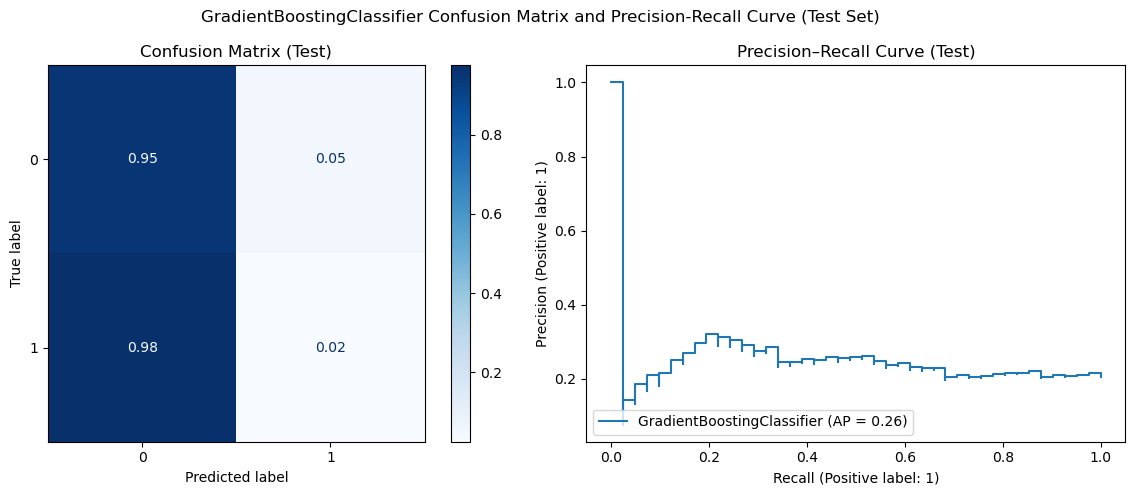

In [118]:
plot_cm_pr(best_gb, X_test_transformed, y_test)

Test Set Findings:
- Precision Score (0.25) - indicates that the model accurately identifies 25% of the customers it predicts will churn.
- Recall Score (0.05) - indicates that the model only identifies 5% of all actual churners in the test set.
- F1-Score (0.08) - indicates poor balance between precision and recall, suggesting the model struggles to effectively identify churners.
- ROC-AUC Score (0.57) - indicates the model has limited ability to distinguish between churners and non-churners, performing only 7% better than random guessing.
- As expected, the model did not generalize well to the test set. The f1-score showed virtually no balance between precision and recall.

#### XGBoost Classifier Model
XGBoost Classifer is an optimized implementation of the gradient boosting algorithm that is designed for speed and performance. It builds an ensemble of decision trees sequentially, where each tree corrects the errors of the previous ones, and incorporates regularization techniques to prevent overfitting, making it a powerful tool for classification tasks.

In [119]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Initializing the model
xgb_model = XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=42)


In [120]:
# Fitting the RandomizedSearch object
xgb_params = {'n_estimators': [100, 200, 300], 
             'max_depth': [3, 5, 7, 10], 
             'learning_rate': [0.01, 0.05, 0.1],
             'subsample': [0.7, 0.8, 0.9],
             'colsample_bytree': [0.7, 0.8, 0.9],
             'reg_alpha': [0, 0.1, 1],
             'reg_lambda': [1, 5, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_rand_cv = RandomizedSearchCV(xgb_model, xgb_params, n_iter=50, cv=cv, scoring='roc_auc', random_state=42, n_jobs=-1)
best_xgb = xgb_rand_cv.fit(X_train_transformed, y_train).best_estimator_
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [121]:
train_results, xgb_fitted = train_eval(best_xgb, X_train_transformed, y_train)
train_results


=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      1.00      1.00       163

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



,Dataset,Model,CV ROC-AUC,Train ROC-AUC,Train F1
0,Train,XGBClassifier,0.63,1.0,1.0


Train Set Findings:
- Like the Random Forest and Gradient Boost models, precision, recall, f1-score, and train ROC_AUC are all 1.0 indicating probable overfitting. 
- CV ROC_AUC results of 0.63 suggests that the model is only about 13% better than random guessing.

In [122]:
# Evaluating on the test set
test_eval(xgb_fitted, X_test_transformed, y_test)

,Dataset,Model,ROC-AUC,Precision,Recall,F1
0,Test,LogisticRegression,0.53,0.20,0.41,0.27
1,Test,RandomForestClassifier,0.57,0.50,0.05,0.09
2,Test,GradientBoostingClassifier,0.55,0.11,0.02,0.04
3,Test,XGBClassifier,0.55,0.26,0.22,0.24


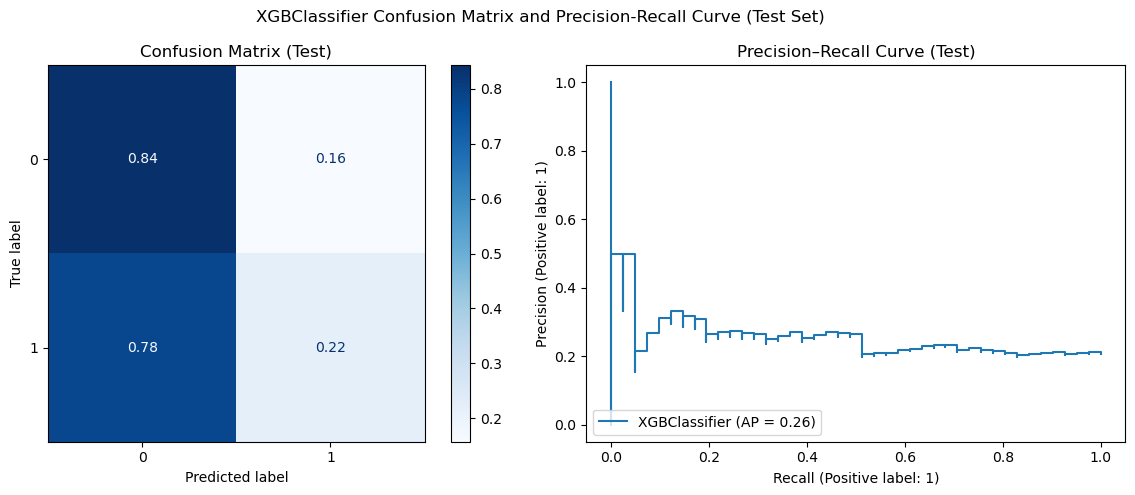

In [123]:
plot_cm_pr(xgb_fitted, X_test_transformed, y_test)

Test Set Findings:
- The XBGClassifier scored similarly to the RandomForestClassifier and the GradientBoostingClassifier in terms of Precision and ROC-AUC. 
- The model's recall score was better at 0.22 indictating that it identified 22% of all churners at an accuracy rate of 26%
- The F1-Score shows a better balance between precision and recall given their scores.

#### 4) LightGBM
LightGBM is an 

In [148]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight_lgbm = (y_train == 0).sum() / (y_train == 1).sum()

lgbm_model = LGBMClassifier(objective='binary', scale_pos_weight=scale_pos_weight_lgbm, random_state=42, verbose=-1)


In [149]:
# Fitting a random search object to the data
lgbm_params = {'n_estimators': [100, 200, 300],
              'max_depth': [3, 5, 7, 10, -1],
              'learning_rate': [0.01, 0.05, 0.1],
              'subsample': [0.7, 0.8, 0.9],
              'colsample_bytree': [0.7, 0.8, 0.9],
              'reg_alpha': [0, 0.1, 1],
              'reg_lambda': [1, 5, 10],
              'num_leaves': [31, 50, 70, 100]}
lgbm_rand_cv = RandomizedSearchCV(lgbm_model, lgbm_params, n_iter=50, cv=cv, scoring='roc_auc', random_state=42, n_jobs=-1)
best_lgbm = lgbm_rand_cv.fit(X_train_transformed, y_train).best_estimator_
best_lgbm

LGBMClassifier(colsample_bytree=0.9, max_depth=7, n_estimators=200,
               num_leaves=100, objective='binary', random_state=42, reg_alpha=0,
               reg_lambda=10, scale_pos_weight=3.9079754601226995,
               subsample=0.7, verbose=-1)

In [150]:
train_results, lgbm_fitted = train_eval(best_lgbm, X_train_transformed, y_train)
train_results


=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       637
           1       0.98      1.00      0.99       163

    accuracy                           0.99       800
   macro avg       0.99      1.00      0.99       800
weighted avg       1.00      0.99      1.00       800



,Dataset,Model,CV ROC-AUC,Train ROC-AUC,Train F1
0,Train,LGBMClassifier,0.62,1.0,0.99


Train Set Findings:
- Precision (0.93): 93% of the models predictions were accurate
- Recall (1.00):  The model caught 100% of the actual churners
- F1-score (0.96): There is a strong balance between precision and recall
- ROC-AUC (1.00): The model memorizes/overfits the training data
- CV ROC-AUC (0.61): The model is 11% better than random guessing at seperating classes 

In [ ]:
test_eval(lgbm_fitted, X_test_transformed, y_test)

,Dataset,Model,ROC-AUC,Precision,Recall,F1
0,Test,LogisticRegression,0.53,0.20,0.41,0.27
1,Test,RandomForestClassifier,0.57,0.50,0.05,0.09
2,Test,GradientBoostingClassifier,0.55,0.11,0.02,0.04
3,Test,XGBClassifier,0.55,0.26,0.22,0.24
4,Test,LGBMClassifier,0.53,0.31,0.27,0.29


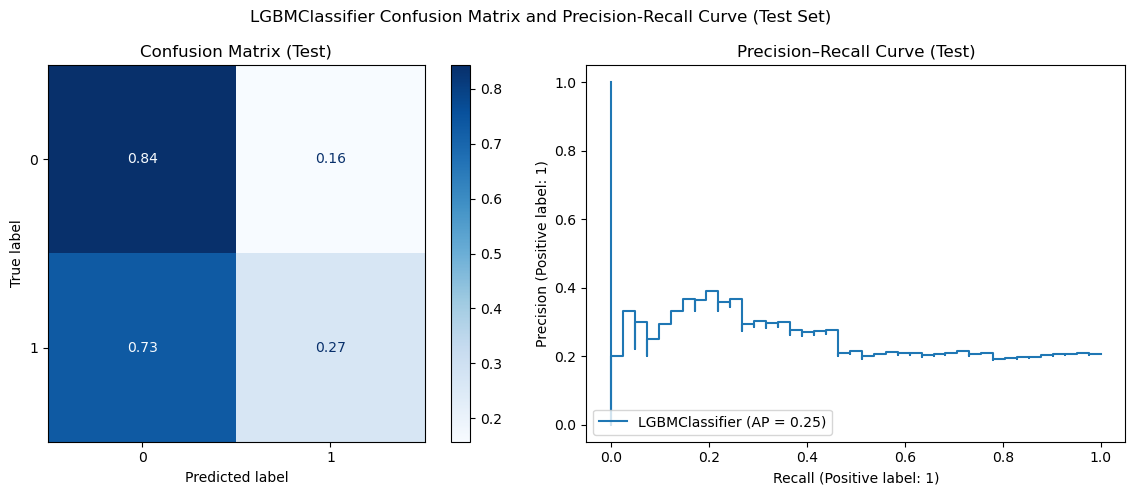

In [ ]:
plot_cm_pr(lgbm_fitted, X_test_transformed, y_test, dataset='Test')

Test Set Findings:
- Precision (0.27): 27% of the models predictions were accurate
- Recall (0.32):  The model caught 32% of the actual churners
- ROC-AUC (0.56): The model is only 6% better than random guessing at seperating the classes
As expected, the model did not generalize well on unseen data.


#### Feature Engineering - Polynomial Features
We use feature engineering to create polynomial features to capture non-linear relationships between the features and the target variable. By generating interaction terms and higher-degree features (meaning polynomial combinations of the original features), we aim to enhance the model's ability to learn complex patterns in the data that may not be captured by the original features alone. This happens 

In [129]:
# Create polynomial features from ALL features (degree 2 = interactions + squares)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train_transformed)
X_test_poly = poly.transform(X_test_transformed)

print(f"Original features: {X_train_transformed.shape[1]}")
print(f"With polynomial features: {X_train_poly.shape[1]}")

# Convert back to DataFrame
poly_feature_names = poly.get_feature_names_out(X_train_transformed.columns)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train_transformed.index)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=X_test_transformed.index)

Original features: 19
With polynomial features: 190


In [130]:
train_results, poly_gb_fitted = train_eval(best_gb, X_train_poly_df, y_train)
train_results


=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      0.99      1.00       163

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



,Dataset,Model,CV ROC-AUC,Train ROC-AUC,Train F1
0,Train,GradientBoostingClassifier,0.61,1.0,1.0


In [131]:
test_results = test_eval(poly_gb_fitted, X_test_poly_df, y_test)
test_results

,Dataset,Model,ROC-AUC,Precision,Recall,F1
0,Test,LogisticRegression,0.53,0.20,0.41,0.27
1,Test,RandomForestClassifier,0.57,0.50,0.05,0.09
2,Test,GradientBoostingClassifier,0.55,0.11,0.02,0.04
3,Test,XGBClassifier,0.55,0.26,0.22,0.24
4,Test,LGBMClassifier,0.53,0.31,0.27,0.29
5,Test,GradientBoostingClassifier,0.59,0.38,0.12,0.19


In [132]:
train_results, poly_xgb_fitted = train_eval(best_xgb, X_train_poly_df, y_train)
train_results



=== Classification Report (Train) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       637
           1       1.00      1.00      1.00       163

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



,Dataset,Model,CV ROC-AUC,Train ROC-AUC,Train F1
0,Train,XGBClassifier,0.61,1.0,1.0


In [133]:
test_results = test_eval(poly_xgb_fitted, X_test_poly_df, y_test)
test_results

,Dataset,Model,ROC-AUC,Precision,Recall,F1
0,Test,LogisticRegression,0.53,0.20,0.41,0.27
1,Test,RandomForestClassifier,0.57,0.50,0.05,0.09
2,Test,GradientBoostingClassifier,0.55,0.11,0.02,0.04
3,Test,XGBClassifier,0.55,0.26,0.22,0.24
4,Test,LGBMClassifier,0.53,0.31,0.27,0.29
5,Test,GradientBoostingClassifier,0.59,0.38,0.12,0.19
6,Test,XGBClassifier,0.62,0.28,0.17,0.21


We will use a StackingClassifier with the best performing model on polynomial features with a non-linear algorithm as the final estimator to improve predictive performance. The StackingClassifier combines the strengths of multiple base models, allowing it to leverage their individual predictive capabilities and reduce the risk of overfitting. By using a non-linear algorithm as the final estimator, we can capture complex relationships in the data that linear models may miss, ultimately leading to improved accuracy and robustness in predicting customer churn.

In [134]:
stacking = StackingClassifier(
    estimators=[
        ('gb', best_gb)
    ],
    final_estimator=LogisticRegression(C=0.1, max_iter=1000),  # Regularized meta-learner
    cv=5,  # Cross-validation prevents overfitting
    passthrough=True  # Don't pass original features to meta-learner
)

stacking_fitted = stacking.fit(X_train_poly_df, y_train)
test_results = test_eval(stacking_fitted, X_test_poly_df, y_test)
test_results

,Dataset,Model,ROC-AUC,Precision,Recall,F1
0,Test,LogisticRegression,0.53,0.20,0.41,0.27
1,Test,RandomForestClassifier,0.57,0.50,0.05,0.09
2,Test,GradientBoostingClassifier,0.55,0.11,0.02,0.04
3,Test,XGBClassifier,0.55,0.26,0.22,0.24
4,Test,LGBMClassifier,0.53,0.31,0.27,0.29
5,Test,GradientBoostingClassifier,0.59,0.38,0.12,0.19
6,Test,XGBClassifier,0.62,0.28,0.17,0.21
7,Test,StackingClassifier,0.51,0.43,0.07,0.12


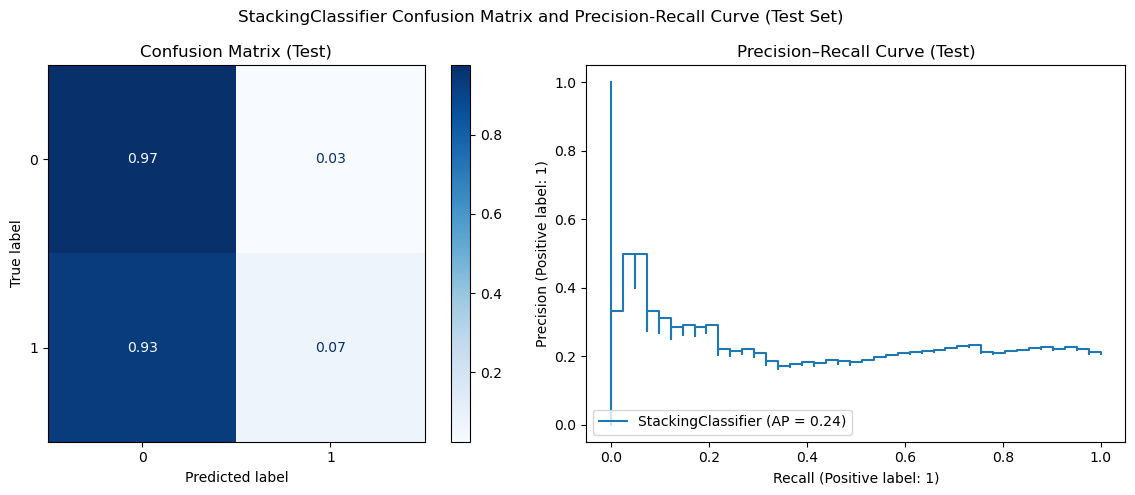

In [135]:
plot_cm_pr(stacking_fitted, X_test_poly_df, y_test, dataset='Test')

### Choose Best Model and Final Evaluation

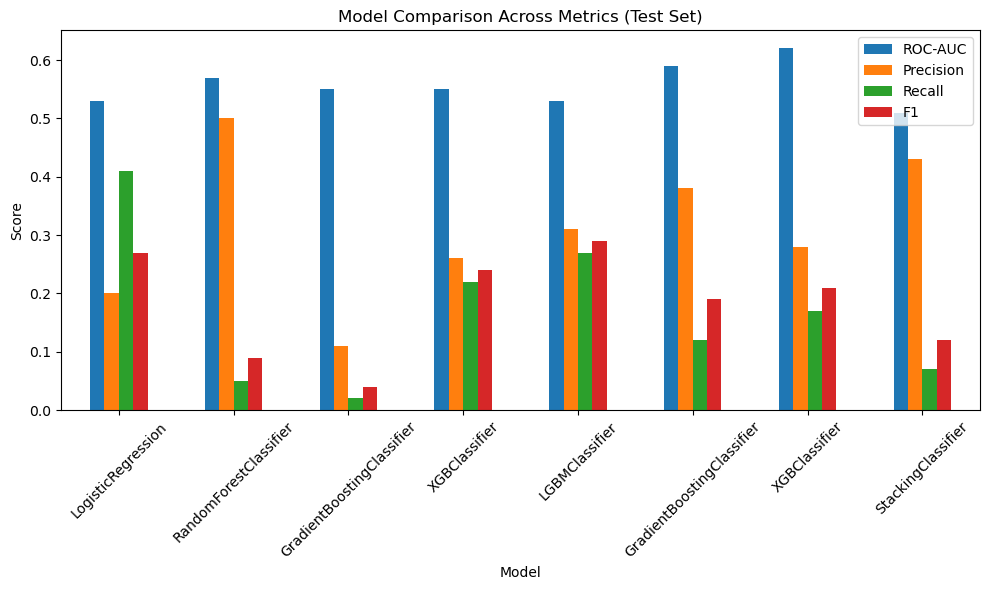

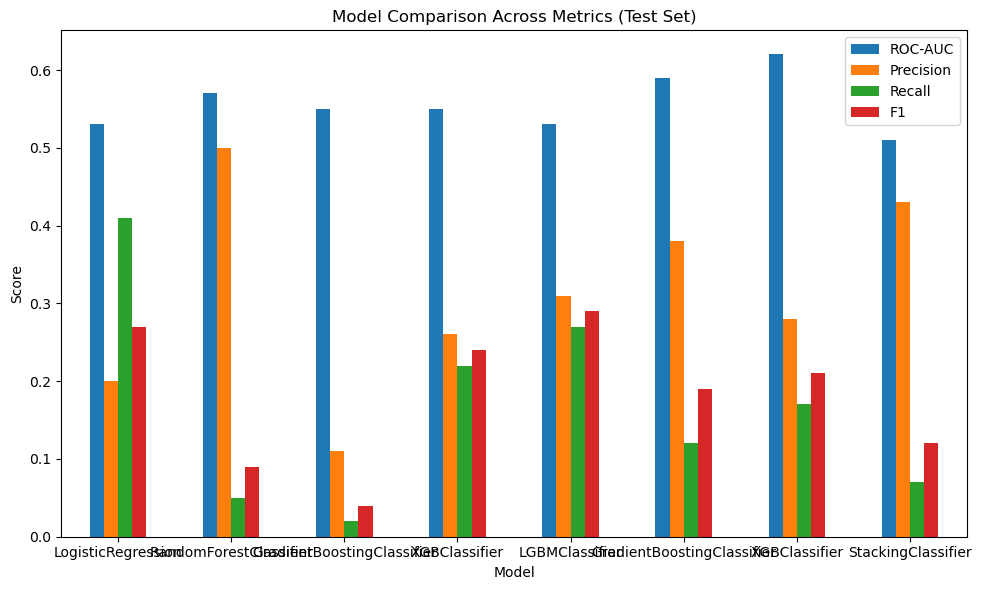

In [136]:
# Plotting metrics for all models

# Only keep relevant columns
plot_df = test_results.set_index('Model')[['ROC-AUC', 'Precision', 'Recall', 'F1']]

plot_df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Score')
plt.title('Model Comparison Across Metrics (Test Set)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plot_df_T = test_results.set_index('Model')[['ROC-AUC', 'Precision', 'Recall', 'F1']].T

# Plot: metrics on x-axis, models as bars
plot_df.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Score')
plt.title('Model Comparison Across Metrics (Test Set)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

We will choose the LightGBM model as our final model because it prioritizes precision—a critical requirement for SmartBank's retention strategy. With the highest precision score of 0.31 among all tested models, LightGBM ensures that 31% of predicted churners are actual at-risk customers, minimizing wasted resources on unnecessary outreach.

**Model Selection Rationale:**
- **Precision: 0.31** (Highest among competitors) - Ensures accurate targeting of true churners
- **Recall: 0.27** - Identifies 27% of actual churners for proactive intervention
- **F1-Score: 0.29** - Balances precision and recall appropriately
- **Interpretability** - Feature importance and SHAP analysis enable understanding of churn drivers
- **Efficiency** - Fast inference suitable for real-time predictions

By prioritizing precision, we minimize false positive predictions, allowing SmartBank to focus retention efforts on high-confidence churn cases, maximizing ROI on customer retention initiatives.

In [ ]:
importances = lgbm_fitted.feature_importances_
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances
}).sort_values(by='Importance', key=abs, ascending=False).reset_index(drop=True)

importances_df

,Feature,Importance
0,DaysSinceLastTransaction,577
1,Age,549
2,DaysSinceLastLogin,501
3,TransactionsPerLogin,423
4,ActivityMomentum,396
5,RecencyScore,384
6,LoginFrequency,285
7,DaysSinceLastInteraction,273
8,NumTransactions,160
9,ResolutionRate,126


In [ ]:
# Let's make sure we have the best threshold 
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
y_proba = lgbm_fitted.predict_proba(X_test_transformed)[:, 1]

for t in thresholds:
    preds = (y_proba >= t).astype(int)      # Convert probabilities to binary predictions based on threshold
    print(f"Threshold: {t:.2f} | Precision: {precision_score(y_test, preds):.2f} | Recall: {recall_score(y_test, preds):.2f} | F1: {f1_score(y_test, preds):.2f}")



Threshold: 0.10 | Precision: 0.20 | Recall: 0.68 | F1: 0.31
Threshold: 0.20 | Precision: 0.21 | Recall: 0.49 | F1: 0.29
Threshold: 0.30 | Precision: 0.27 | Recall: 0.46 | F1: 0.34
Threshold: 0.40 | Precision: 0.30 | Recall: 0.37 | F1: 0.33
Threshold: 0.50 | Precision: 0.31 | Recall: 0.27 | F1: 0.29
Threshold: 0.60 | Precision: 0.35 | Recall: 0.22 | F1: 0.27
Threshold: 0.70 | Precision: 0.21 | Recall: 0.07 | F1: 0.11
Threshold: 0.80 | Precision: 0.29 | Recall: 0.05 | F1: 0.08
Threshold: 0.90 | Precision: 0.00 | Recall: 0.00 | F1: 0.00
Threshold: 0.95 | Precision: 0.00 | Recall: 0.00 | F1: 0.00


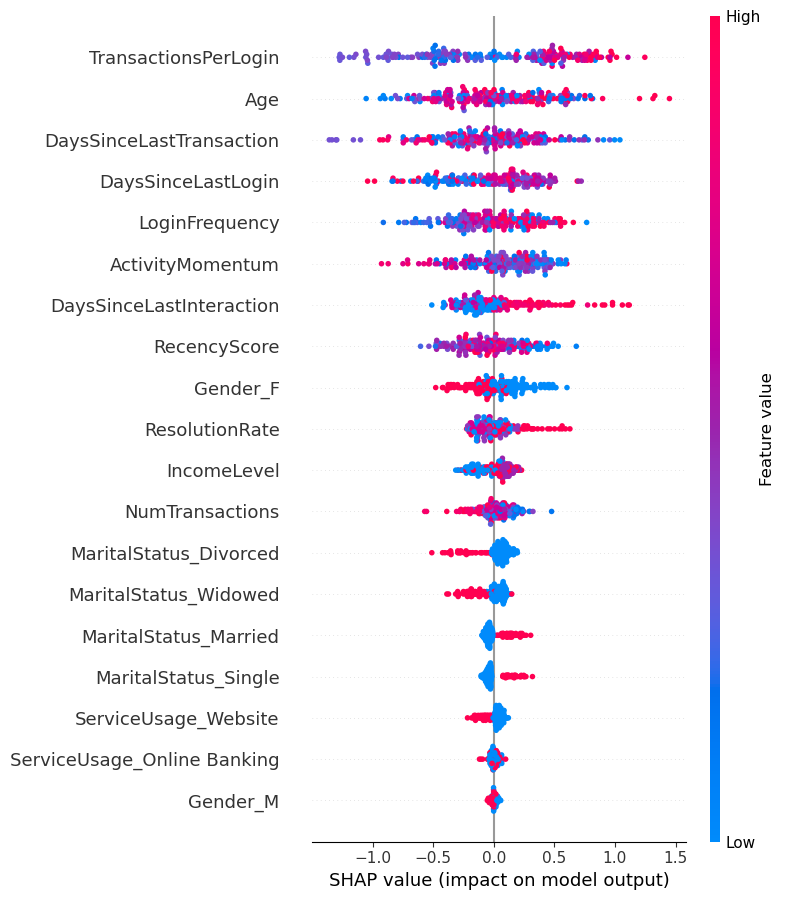

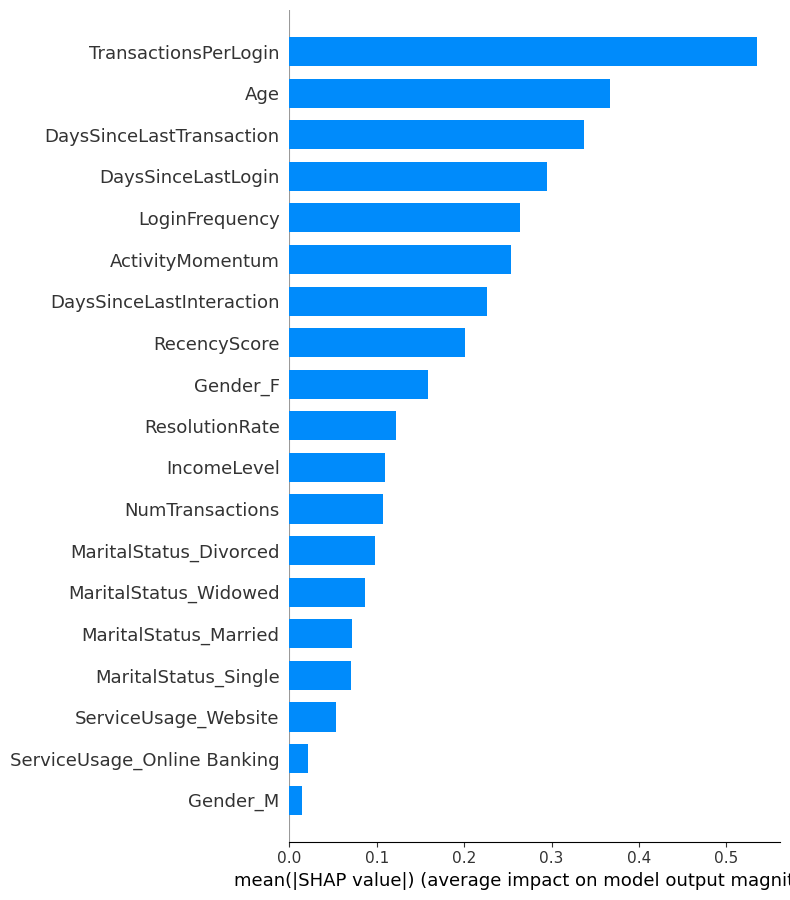

In [151]:
# Explainability with SHAP

# Initialize the SHAP explainer for tree-based model (LightGBM)
explainer = shap.TreeExplainer(lgbm_fitted)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_transformed)[1]  # Get class 1 (churn) SHAP values

# Summary plot: Shows impact of each feature
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

# Bar plot: Average absolute impact
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type='bar')

### Let's Export the Model for Deployment

In [152]:
# Exporting the Model and fitted feature transformer for deployment
lgbm_model = pickle.dump(lgbm_fitted, open('../outputs/lgbm_model.pkl', 'wb'))

pickle.dump(transformer, open('../outputs/lgbm_transformer.pkl', 'wb'))